# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.


In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load in the data
azdias = pd.read_csv('./Udacity_AZDIAS_052018.csv')
customers = pd.read_csv('./Udacity_CUSTOMERS_052018.csv')

/root/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Data missing plot

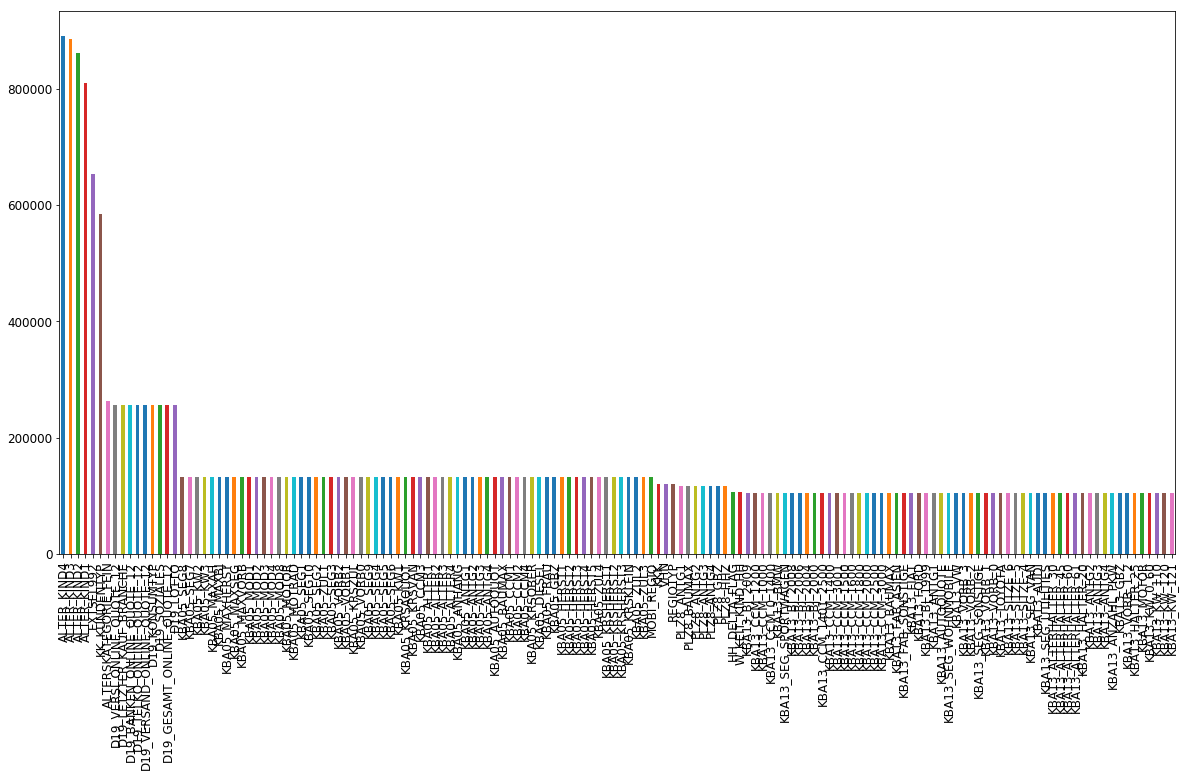

In [17]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!
# azdias.head()  #人口统计学数据  891 211 persons (rows) x 366 features (columns).
azdias.isnull().sum().sort_values(ascending=False)[:150].plot.bar(figsize=(20,10),fontsize=12)

### Missing data rating

In [21]:
round(azdias.isnull().sum()/azdias.shape[0]*100,1).sort_values(ascending=False)[:20]

ALTER_KIND4                    99.9
ALTER_KIND3                    99.3
ALTER_KIND2                    96.7
ALTER_KIND1                    90.9
EXTSEL992                      73.4
KK_KUNDENTYP                   65.6
ALTERSKATEGORIE_FEIN           29.5
D19_VERSI_ONLINE_QUOTE_12      28.8
D19_LETZTER_KAUF_BRANCHE       28.8
D19_BANKEN_ONLINE_QUOTE_12     28.8
D19_TELKO_ONLINE_QUOTE_12      28.8
D19_VERSAND_ONLINE_QUOTE_12    28.8
D19_KONSUMTYP                  28.8
D19_SOZIALES                   28.8
D19_GESAMT_ONLINE_QUOTE_12     28.8
D19_LOTTO                      28.8
KBA05_SEG8                     15.0
KBA05_SEG7                     15.0
KBA05_KW2                      15.0
KBA05_KW3                      15.0
dtype: float64

In [5]:
## Part 1: Customer Segmentation Report

# The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

#### According DIAS Attributes - Values 2017.xlsx and DIAS Information Levels - Attributes 2017.xlsx document describe,  to find all fature missing data how to fill

In [24]:
#  -1 unknow columns
col_1 = [
    "AGER_TYP","BALLRAUM","SHOPPER_TYP","VERS_TYP",
    "CAMEO_DEUG_2015","EWDICHTE","ORTSGR_KLS9","OST_WEST_KZ","PLZ8_GBZ","PLZ8_HHZ",
"FINANZTYP","FINANZ_ANLEGER","FINANZ_HAUSBAUER","FINANZ_MINIMALIST","FINANZ_SPARER","FINANZ_UNAUFFAELLIGER","FINANZ_VORSORGER",
"HEALTH_TYP","INNENSTADT", 
    'D19_KONSUMTYP',"KK_KUNDENTYP","PLZ8_BAUMAX","GREEN_AVANTGARDE"
]

In [25]:
#  -1, unknow columns
col_1_9 = ["KBA05_ALTER1","KBA05_ALTER2","KBA05_ALTER3","KBA05_ALTER4","KBA05_ANHANG",
           "KBA05_AUTOQUOT","KBA05_CCM1","KBA05_CCM2","KBA05_CCM3","KBA05_CCM4","KBA05_DIESEL",
           "KBA05_FRAU","KBA05_HERST1","KBA05_HERST2","KBA05_HERST3","KBA05_HERST4","KBA05_HERST5",
           "KBA05_HERSTTEMP","KBA05_KRSAQUOT","KBA05_KRSHERST1","KBA05_KRSHERST2","KBA05_KRSHERST3",
           "KBA05_KRSKLEIN","KBA05_KRSOBER","KBA05_KRSVAN","KBA05_KRSZUL","KBA05_KW1","KBA05_KW2","KBA05_KW3","KBA05_MAXAH",
           "KBA05_MAXBJ","KBA05_MAXHERST","KBA05_MAXSEG","KBA05_MAXVORB","KBA05_MOD1",
            "KBA05_MOD2","KBA05_MOD3","KBA05_MOD4","KBA05_MODTEMP","KBA05_MOTOR","KBA05_SEG1","KBA05_SEG10",
           "KBA05_SEG2","KBA05_SEG3","KBA05_SEG4","KBA05_SEG5","KBA05_SEG6","KBA05_SEG7","KBA05_SEG8","KBA05_SEG9",
           "KBA05_VORB0","KBA05_VORB1","KBA05_VORB2","KBA05_ZUL1","KBA05_ZUL2","KBA05_ZUL3",
            "KBA05_ZUL4","RELAT_AB","SEMIO_DOM","SEMIO_ERL","SEMIO_FAM","SEMIO_KAEM","SEMIO_KRIT","SEMIO_KULT","SEMIO_LUST",
           "SEMIO_MAT","SEMIO_PFLICHT","SEMIO_RAT","SEMIO_REL","SEMIO_SOZ","SEMIO_TRADV","SEMIO_VERT","ZABEOTYP"]
#  -1, 0 unknow columns
col_1_0 = [
    "ALTERSKATEGORIE_GROB","ANREDE_KZ","GEBAEUDETYP","GEBAEUDETYP","HH_EINKOMMEN_SCORE","KBA05_BAUMAX","KBA05_GBZ","KKK",
    "NATIONALITAET_KZ","PRAEGENDE_JUGENDJAHRE","REGIOTYP","TITEL_KZ","WOHNDAUER_2008","W_KEIT_KIND_HH","RETOURTYP_BK_S",
   
    'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4',
       'KBA05_MOD8', 'KBA05_MOTRAD', 'KBA13_ALTERHALTER_45',
       'KBA13_ANZAHL_PKW', 'KBA13_TOYOTA', 'KBA13_VORB_2', 'KONSUMNAEHE',
       'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_LEBENSPHASE_FEIN',
       'LP_LEBENSPHASE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'MOBI_REGIO',
       'ONLINE_AFFINITAET', 'ALTER_HH', 'ARBEIT', 'CJT_GESAMTTYP',
       'GEBAEUDETYP_RASTER', 'GFK_URLAUBERTYP'
]

#  -1 Unknow, 0 None  KBA13_CCM_1400_2500  change to KBA13_CCM_1401_2500
col_1_0_none = [
    "KBA13_ALTERHALTER_30","KBA13_ALTERHALTER_60","KBA13_ALTERHALTER_61","KBA13_AUDI","KBA13_AUTOQUOTE","KBA13_BJ_1999","KBA13_BJ_2000",
"KBA13_BJ_2004","KBA13_BJ_2006","KBA13_BJ_2008","KBA13_BJ_2009","KBA13_BMW","KBA13_CCM_1000","KBA13_CCM_1200","KBA13_CCM_1400",
"KBA13_CCM_0_1400","KBA13_CCM_1500","KBA13_CCM_1401_2500","KBA13_CCM_1600","KBA13_CCM_1800","KBA13_CCM_2000","KBA13_CCM_2500",
"KBA13_CCM_2501","KBA13_CCM_3000","KBA13_CCM_3001","KBA13_FAB_ASIEN","KBA13_FAB_SONSTIGE","KBA13_FIAT","KBA13_FORD","KBA13_HALTER_20",
"KBA13_HALTER_25","KBA13_HALTER_30","KBA13_HALTER_35","KBA13_HALTER_40","KBA13_HALTER_45","KBA13_HALTER_50","KBA13_HALTER_55",
"KBA13_HALTER_60","KBA13_HALTER_65","KBA13_HALTER_66","KBA13_HERST_ASIEN","KBA13_HERST_AUDI_VW","KBA13_HERST_BMW_BENZ",
"KBA13_HERST_EUROPA","KBA13_HERST_FORD_OPEL","KBA13_HERST_SONST","KBA13_KMH_110","KBA13_KMH_140","KBA13_KMH_180","KBA13_KMH_0_140",
"KBA13_KMH_140_210","KBA13_KMH_211","KBA13_KMH_250","KBA13_KMH_251","KBA13_KRSAQUOT","KBA13_KRSHERST_AUDI_VW","KBA13_KRSHERST_BMW_BENZ",
"KBA13_KRSHERST_FORD_OPEL","KBA13_KRSSEG_KLEIN","KBA13_KRSSEG_OBER","KBA13_KRSSEG_VAN","KBA13_KRSZUL_NEU","KBA13_KW_30","KBA13_KW_40",
"KBA13_KW_50","KBA13_KW_60","KBA13_KW_0_60","KBA13_KW_70","KBA13_KW_61_120","KBA13_KW_80","KBA13_KW_90","KBA13_KW_110",
"KBA13_KW_120","KBA13_KW_121","KBA13_MAZDA","KBA13_MERCEDES","KBA13_MOTOR","KBA13_NISSAN","KBA13_OPEL","KBA13_PEUGEOT","KBA13_RENAULT",
"KBA13_SEG_GELAENDEWAGEN","KBA13_SEG_GROSSRAUMVANS","KBA13_SEG_KLEINST","KBA13_SEG_KLEINWAGEN","KBA13_SEG_KOMPAKTKLASSE","KBA13_SEG_MINIVANS",
"KBA13_SEG_MINIWAGEN","KBA13_SEG_MITTELKLASSE","KBA13_SEG_OBEREMITTELKLASSE","KBA13_SEG_OBERKLASSE","KBA13_SEG_SONSTIGE",
"KBA13_SEG_SPORTWAGEN","KBA13_SEG_UTILITIES","KBA13_SEG_VAN","KBA13_SEG_WOHNMOBILE","KBA13_SITZE_4","KBA13_SITZE_5","KBA13_SITZE_6",
"KBA13_VORB_0","KBA13_VORB_1","KBA13_VORB_1_2","KBA13_VORB_3","KBA13_VW","PLZ8_ANTG1","PLZ8_ANTG2","PLZ8_ANTG3","PLZ8_ANTG4","WOHNLAGE"
]

# 0 is no_transactions_known
no_transactions_known_0=[
    "D19_BANKEN_DIREKT","D19_BANKEN_GROSS","D19_BANKEN_LOKAL","D19_BANKEN_REST",
    "D19_BEKLEIDUNG_GEH","D19_BEKLEIDUNG_REST","D19_BILDUNG","D19_BIO_OEKO","D19_BUCH_CD",
    "D19_DIGIT_SERV","D19_DROGERIEARTIKEL","D19_ENERGIE","D19_FREIZEIT","D19_GARTEN","D19_GESAMT_ANZ_12","D19_GESAMT_ANZ_24",
    "D19_HANDWERK","D19_HAUS_DEKO","D19_KINDERARTIKEL","D19_KOSMETIK","D19_LEBENSMITTEL",
    "D19_LOTTO","D19_NAHRUNGSERGAENZUNG","D19_RATGEBER","D19_REISEN","D19_SAMMELARTIKEL","D19_SCHUHE",
    "D19_SONSTIGE","D19_TECHNIK","D19_TELKO_ANZ_12","D19_TELKO_ANZ_24",
    "D19_TELKO_MOBILE","D19_TELKO_REST","D19_TIERARTIKEL","D19_VERSAND_ANZ_12","D19_VERSAND_ANZ_24","D19_VERSAND_REST",
    "D19_VERSICHERUNGEN","D19_VERSI_ANZ_12","D19_VERSI_ANZ_24","D19_VOLLSORTIMENT","D19_WEIN_FEINKOST",
    'D19_BANKEN_ANZ_12',
 'D19_BANKEN_ANZ_24'
]

# no_transactions_known at 10
no_transactions_known_10=[
    "D19_BANKEN_DATUM","D19_BANKEN_OFFLINE_DATUM","D19_BANKEN_ONLINE_DATUM","D19_GESAMT_DATUM",
    "D19_GESAMT_OFFLINE_DATUM","D19_GESAMT_ONLINE_DATUM","D19_TELKO_DATUM","D19_TELKO_OFFLINE_DATUM",
    "D19_TELKO_ONLINE_DATUM","D19_VERSAND_DATUM","D19_VERSAND_OFFLINE_DATUM","D19_VERSAND_ONLINE_DATUM"
]

# no Online-transactions within the last 12 months
Online_transactions = [
    "D19_BANKEN_ONLINE_QUOTE_12","D19_GESAMT_ONLINE_QUOTE_12","D19_VERSAND_ONLINE_QUOTE_12"
]

#  numeric columns
numeric_col=[
    "ANZ_HAUSHALTE_AKTIV","ANZ_HH_TITEL","ANZ_PERSONEN","ANZ_TITEL","MIN_GEBAEUDEJAHR",
    "GEBURTSJAHR"
]

In [26]:
no_Domain_description = ['KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_MOD8', 'KBA05_MOTRAD', 'KBA13_ALTERHALTER_45',
                         'KBA13_ANZAHL_PKW', 'KBA13_TOYOTA', 'KBA13_VORB_2', 'KONSUMNAEHE', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB',
                         'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB',
 'MOBI_REGIO', 'ONLINE_AFFINITAET', 'ALTER_HH', 'ARBEIT', 'CJT_GESAMTTYP', 'GEBAEUDETYP_RASTER', 'GEBURTSJAHR', 'GREEN_AVANTGARDE',
 'GFK_URLAUBERTYP']

#  at word no feature
no_feature = [
     'KBA13_ANTG1', 'KBA13_ANTG2','KBA13_ANTG3','KBA13_ANTG4',"LNR","D19_VERSI_OFFLINE_DATUM","D19_TELKO_ONLINE_QUOTE_12",
    "D19_VERSI_ONLINE_QUOTE_12","KBA13_BAUMAX","KBA13_GBZ","KBA13_HHZ","KBA13_KMH_210","KOMBIALTER","KONSUMZELLE",
     'CJT_TYP_1','CJT_TYP_2','CJT_TYP_3','CJT_TYP_4','CJT_TYP_5','CJT_TYP_6', "D19_KONSUMTYP_MAX",
    "D19_SOZIALES","D19_VERSI_DATUM","D19_VERSI_ONLINE_DATUM","AKT_DAT_KL",'ALTER_KIND1',
    "ALTERSKATEGORIE_FEIN","ANZ_KINDER","ANZ_STATISTISCHE_HAUSHALTE","CJT_KATALOGNUTZER",
    'UMFELD_ALT','UMFELD_JUNG','RT_KEIN_ANREIZ', 'RT_SCHNAEPPCHEN',"DSL_FLAG","EINGEZOGENAM_HH_JAHR",
    "FIRMENDICHTE","GEMEINDETYP","HH_DELTA_FLAG","KBA13_ANTG4","MOBI_RASTER","RT_UEBERGROESSE","SOHO_KZ",
    "STRUKTURTYP","UNGLEICHENN_FLAG","VERDICHTUNGSRAUM","VK_ZG11","VK_DHT4A","VHN","VHA","VK_DISTANZ" 
]

In [27]:
#accoring above this columns missing above 30%
drop_col = ["EINGEFUEGT_AM","ALTER_KIND2","ALTER_KIND3","ALTER_KIND4","EXTSEL992","GEBURTSJAHR","LNR","EINGEZOGENAM_HH_JAHR"]

In [28]:
# String columns
string_col=["CAMEO_DEU_2015","OST_WEST_KZ","D19_LETZTER_KAUF_BRANCHE","CAMEO_INTL_2015"]

In [29]:
null_process = [
    "D19_TELKO_ONLINE_QUOTE_12","D19_VERSI_ONLINE_QUOTE_12","D19_SOZIALES","ALTER_KIND1","ALTERSKATEGORIE_FEIN","UMFELD_ALT","UMFELD_JUNG",
"GEMEINDETYP","RT_UEBERGROESSE","STRUKTURTYP","VERDICHTUNGSRAUM","VHN"
]
no_feature1 = [i for i in no_feature if i not in null_process]

In [30]:
scale_columns = ["KBA13_ANZAHL_PKW","ANZ_STATISTISCHE_HAUSHALTE"]

## Missing  Data Process

In [31]:
# no document describe feature
drop_no_feature = ["LNR","EINGEZOGENAM_HH_JAHR"]

In [32]:
azdias[no_feature].fillna(azdias[no_feature].median(),inplace = True)

In [33]:
def fill_missing_values(cols,na,df):
    df[cols] = df[cols].fillna(na)
    return df

In [34]:
from sklearn.preprocessing import StandardScaler
def clearn_data_other(data,rate = 0.2):
    
    limit_percent = rate
    limit_value = len(data) * limit_percent
    drop_null = data.columns[data.isnull().sum() > limit_value]
    
    df = fill_missing_values(col_1,-1,data)
    df = fill_missing_values(col_1_0,-1,df)
    df = fill_missing_values(col_1_9,-1,df)
    df = fill_missing_values(col_1_0_none,-1,df)
    df = fill_missing_values(no_transactions_known_0,0,df)
    df = fill_missing_values(no_transactions_known_10,10,df)
    df = fill_missing_values(Online_transactions,0,df)
    df = fill_missing_values(Online_transactions,0,df)
    df[numeric_col] = df[numeric_col].fillna(df[numeric_col].mean())
    df[no_Domain_description] = df[no_Domain_description].fillna(df[no_Domain_description].median())
#     df[no_feature] = df[no_feature].fillna(df[no_feature].median())
    for n in no_feature:
        df[n] = df[n].fillna(df[n].median())
    df = df.drop(drop_col,axis=1)
    df[string_col] = df[string_col].fillna(-1).astype(str)
    df["CAMEO_DEUG_2015"] = df["CAMEO_DEUG_2015"].replace('X',-1)
    df["CAMEO_DEUG_2015"] = df["CAMEO_DEUG_2015"].astype(int)
    from sklearn.preprocessing import StandardScaler,LabelEncoder
    df[scale_columns] = df[scale_columns].fillna(df[scale_columns].median())
    scale = StandardScaler()
    scale.fit(df[scale_columns])
    df[scale_columns] = scale.transform(df[scale_columns])
    le = LabelEncoder()
    for col in  string_col:
        le.fit(df[col])
        df[col] = le.transform(df[col])
    
    drop_null1 = [i for i in drop_null if i in df.columns]
    drop_null2 = [i for i in drop_null1 if i in df.columns]
    df = df.drop(drop_null2,axis=1)
    
    return df

In [35]:
azdias = azdias.drop("Unnamed: 0",axis=1)

 #### Missing Processing

In [36]:
df = clearn_data_other(azdias)

### customers data explore

In [60]:
customers_ = customers.drop(['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'],axis=1)
customer = clearn_data_other(customers_)

In [19]:
customer[['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']] = customers[['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']]

In [20]:
customer[['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']].groupby("CUSTOMER_GROUP").count()

,ONLINE_PURCHASE,PRODUCT_GROUP
CUSTOMER_GROUP,,
MULTI_BUYER,132238,132238
SINGLE_BUYER,59414,59414


In [21]:
customer[['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']].groupby("ONLINE_PURCHASE").count()

,CUSTOMER_GROUP,PRODUCT_GROUP
ONLINE_PURCHASE,,
0,174356,174356
1,17296,17296


In [22]:
customer[['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']].groupby("PRODUCT_GROUP").count()

,CUSTOMER_GROUP,ONLINE_PURCHASE
PRODUCT_GROUP,,
COSMETIC,43410,43410
COSMETIC_AND_FOOD,100860,100860
FOOD,47382,47382


In [36]:
customers_ = customers.drop(['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'],axis=1)
customer = clearn_data_other(customers_)
X  =  customer
y = customers['ONLINE_PURCHASE']
from sklearn.metrics import classification_report
def gridsearch_cv(model, test_param, X, y, cv=5): 
    RandomizedSearchCV
#     gsearch = GridSearchCV(model,test_param, scoring='roc_auc', n_jobs= -1, iid=False, cv=cv) 
    gsearch = RandomizedSearchCV(model,test_param, scoring='roc_auc', n_jobs= -1, iid=False, cv=cv) 
    gsearch.fit(X, y) 
    return gsearch.best_estimator_

In [34]:
# y = y.map({"MULTI_BUYER":0,"SINGLE_BUYER":1})
# y = y.map({"COSMETIC":0,"COSMETIC_AND_FOOD":1,"FOOD":3})

In [226]:
customer['PRODUCT_GROUP'] = customers['PRODUCT_GROUP'].map({"COSMETIC":0,"COSMETIC_AND_FOOD":1,"FOOD":3})
customer['CUSTOMER_GROUP'] = customers['CUSTOMER_GROUP'].map({"MULTI_BUYER":0,"SINGLE_BUYER":1})
customer['ONLINE_PURCHASE'] = customers['ONLINE_PURCHASE']

In [37]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

rf = RandomForestClassifier(random_state=42)
params = {
    'bootstrap' : [True,False],
    'max_depth' :range(5,20),
    'max_features' : range(1,11),
    'criterion' :['gini','entropy']
}
best_rf = gridsearch_cv(rf,params,X_train,y_train,5)
best_predictions = best_rf.predict_proba(X_test)


In [180]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train,y_train)
best_predictions = rf.predict(X_test)
print(classification_report(y_test, best_predictions))

             precision    recall  f1-score   support

          0       0.25      0.18      0.21     14329
          1       0.55      0.72      0.62     33228
          3       0.31      0.19      0.24     15689

avg / total       0.42      0.46      0.43     63246



### CUSTOMER_GROUP feature importence analysis

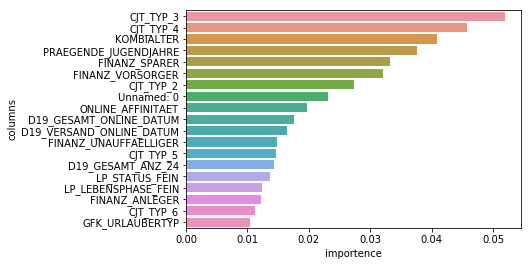

In [181]:
data_import = pd.DataFrame({"columns":customer.columns,"importence":best_rf.feature_importances_},)
sns.barplot(y = "columns",x="importence",data = data_import.sort_values("importence",ascending=False).iloc[1:20])

### ONLINE_PURCHASE feature importence analysis

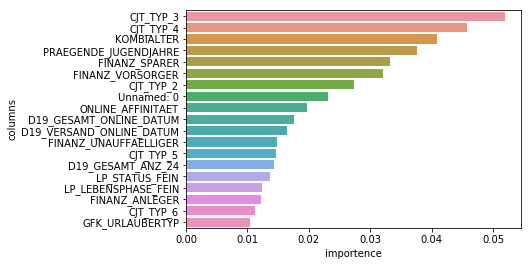

In [155]:
data_import = pd.DataFrame({"columns":customer.columns,"importence":best_rf.feature_importances_},)
sns.barplot(y = "columns",x="importence",data = data_import.sort_values("importence",ascending=False).iloc[1:20])

### PRODUCT_GROUP feature importence analysis

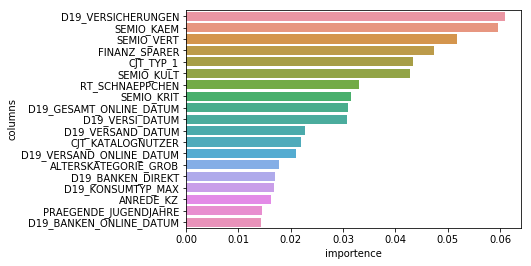

In [150]:
sns.barplot(y = "columns",x="importence",data = data_import.sort_values("importence",ascending=False).iloc[1:20])

### Use PCA Dimensionality reduction analysis

In [37]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import MeanShift
from sklearn.metrics import silhouette_score
import time
import warnings
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

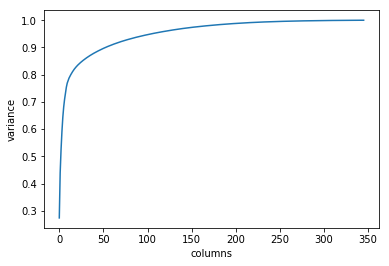

In [38]:
pca = PCA().fit(df)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('columns')
plt.ylabel('variance')
plt.show()

In [40]:
def pca_data(df,n=2):
    pca = PCA(n_components=n).fit(df)
    pca_data = pca.transform(df)
    pca_data = pd.DataFrame(pca_data, columns = ['Dimension 1', 'Dimension 2'])
#     pca_data = pd.DataFrame(pca_data, columns = ['Dimension 1', 'Dimension 2','Dimension 3', 'Dimension 4'])
    print(pca.explained_variance_ratio_.sum())
    return pca_data
sample = df.sample(10000)
reduced_azdias = pca_data(sample)
reduced_customers = pca_data(customer)

0.43910664861233945


In [41]:
def kmean_score(i,s,df):
    clusterer = KMeans(n_clusters=i, random_state=42).fit(df)
    sample = df.sample(10000)
        # TODO：预测每一个点的簇
    preds = clusterer.predict(sample)
        # TODO：计算选择的类别的平均轮廓系数（mean silhouette coefficient）
    score = silhouette_score(sample, preds, metric='sqeuclidean')
    print("silhouette_socre ",i,"cluster",score)
    return score

In [42]:
X_index = []
Y_score = []
for i in range(2,15):
    X_index.append(i)
    score = kmean_score(i,10000,df)
    Y_score.append(score)

silhouette_socre  2 cluster 0.31593651142420104
silhouette_socre  3 cluster 0.36182792298979816
silhouette_socre  4 cluster 0.3753182896938006
silhouette_socre  5 cluster 0.31538661930903916
silhouette_socre  6 cluster 0.2804127667884825
silhouette_socre  7 cluster 0.2479473794955983
silhouette_socre  8 cluster 0.2604193003905407
silhouette_socre  9 cluster 0.24798079507811885
silhouette_socre  10 cluster 0.2697827219656749
silhouette_socre  11 cluster 0.24743574340824112
silhouette_socre  12 cluster 0.24175306533565413
silhouette_socre  13 cluster 0.2265150428877821
silhouette_socre  14 cluster 0.2183534381609547


### According silhouette score cluster 4 class is best

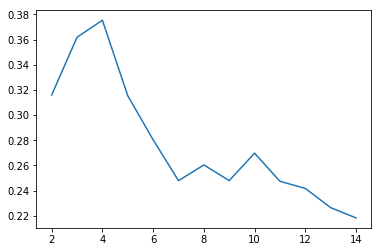

In [43]:
plt.plot(X_index,Y_score)

In [44]:
reduced_azdias.head()

,Dimension 1,Dimension 2
0,-48.743186,34.925377
1,-10.639377,-23.691867
2,43.024844,11.772076
3,-13.509275,-22.267908
4,23.863765,0.472821


In [45]:
data = df.sample(10000)

### Find azdias data feature importence

In [46]:
import pandas as pd
from  sklearn.model_selection import train_test_split
from sklearn import tree
feture_col = []
score_col = []
for feture in data.columns:
    new_data = data.drop([feture],axis=1)
    # TODO：使用给定的特征作为目标，将数据分割成训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(new_data,data[feture] ,test_size=0.25,random_state = 42)
    clf = tree.DecisionTreeRegressor(random_state = 42)
    # TODO：创建一个DecisionTreeRegressor（决策树回归器）并在训练集上训练它
    regressor = clf.fit(X_train,y_train)
    # TODO：输出在测试集上的预测得分
    score = clf.score(X_test,y_test)
    feture_col.append(feture)
    score_col.append(score)

In [47]:
feature_socre = pd.DataFrame({"feature":feture_col,"score":score_col})
feature_socre.sort_values("score").iloc[:10]

,feature,score
327,SOHO_KZ,-1.651732
36,D19_DIGIT_SERV,-1.066833
66,D19_TIERARTIKEL,-0.926120
27,D19_BANKEN_LOKAL,-0.852497
51,D19_LEBENSMITTEL,-0.823037
94,GFK_URLAUBERTYP,-0.803563
64,D19_TELKO_ONLINE_DATUM,-0.760967
50,D19_KOSMETIK,-0.729610
33,D19_BILDUNG,-0.720439
55,D19_SAMMELARTIKEL,-0.703288


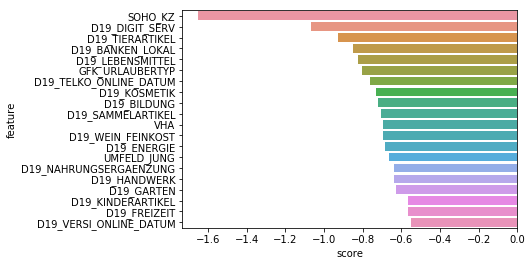

In [48]:
sns.barplot(y = "feature",x="score",data =feature_socre.sort_values("score").iloc[:20])

In [49]:
clusterer = KMeans(n_clusters=4,random_state=42).fit(reduced_azdias)
preds = clusterer.predict(reduced_azdias)
sample["class"] = preds

### 4 class of data distribution

/root/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: pandas.scatter_matrix is deprecated, use pandas.plotting.scatter_matrix instead
  """Entry point for launching an IPython kernel.


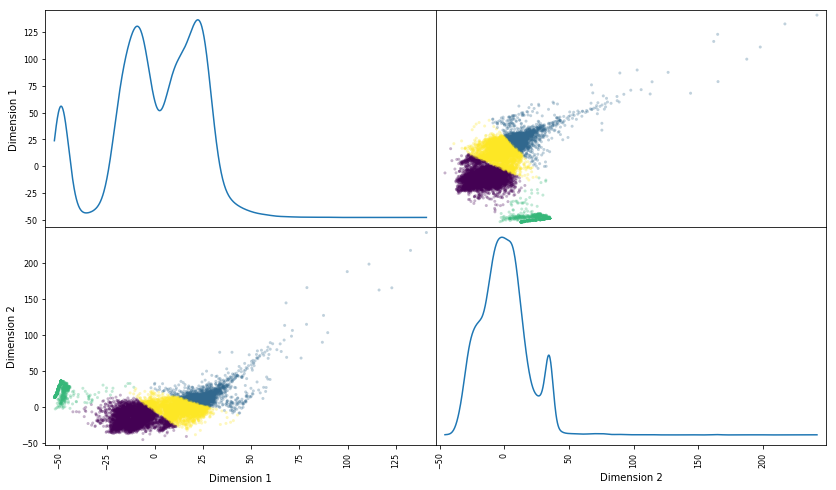

In [50]:
pd.scatter_matrix(reduced_azdias, alpha = 0.3, figsize = (14,8), diagonal = 'kde',c = preds)
plt.show()

### 4 class data density distribution

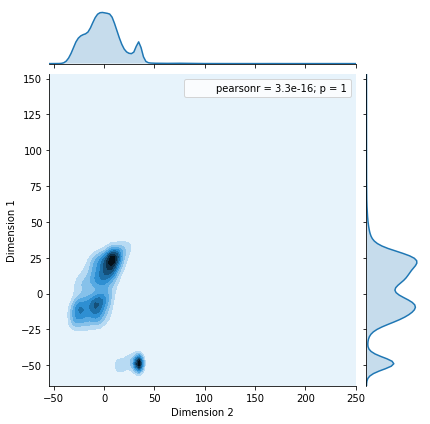

In [52]:
sns.jointplot(reduced_azdias.iloc[:,1],reduced_azdias.iloc[:,0],kind= 'kde')

In [55]:
azdias_sample = reduced_azdias.sample(10000)
clusterer = KMeans(n_clusters=4,random_state=42).fit(azdias_sample)
s_preds = clusterer.predict(azdias_sample)
azdias_sample["class"] = s_preds

/root/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'kind', 'color'
  s)


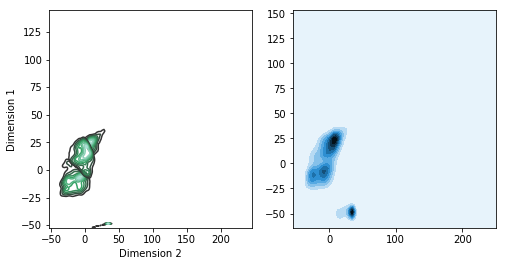

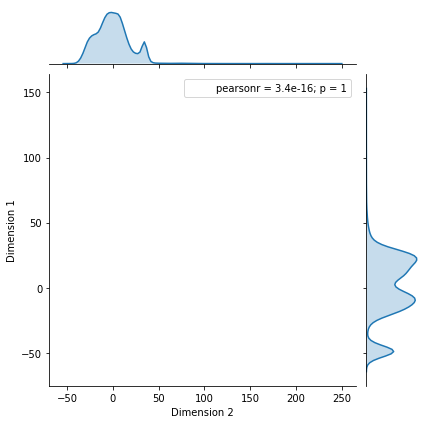

In [56]:
f, (ax1,ax2) =plt.subplots(1,2,figsize=(8,4))
# sns.kdeplot(df.x, df.y, ax=ax)
# sns.rugplot(df.x, color="g", ax=ax)
# sns.rugplot(df.y, vertical=True, ax=ax)

sns.kdeplot(azdias_sample[azdias_sample["class"]==0].iloc[:,1],azdias_sample[azdias_sample["class"]==0].iloc[:,0],kind= 'kde',color="g",ax=ax1)
sns.kdeplot(azdias_sample[azdias_sample["class"]==1].iloc[:,1],azdias_sample[azdias_sample["class"]==1].iloc[:,0],kind= 'kde',color="g",ax=ax1)
sns.kdeplot(azdias_sample[azdias_sample["class"]==2].iloc[:,1],azdias_sample[azdias_sample["class"]==2].iloc[:,0],kind= 'kde',color="g",ax=ax1)
sns.kdeplot(azdias_sample[azdias_sample["class"]==3].iloc[:,1],azdias_sample[azdias_sample["class"]==3].iloc[:,0],kind= 'kde',color="g",ax=ax1)

sns.jointplot(azdias_sample.iloc[:,1],azdias_sample.iloc[:,0],kind= 'kde', ax = ax2)

###  Class 4 data plane distributed

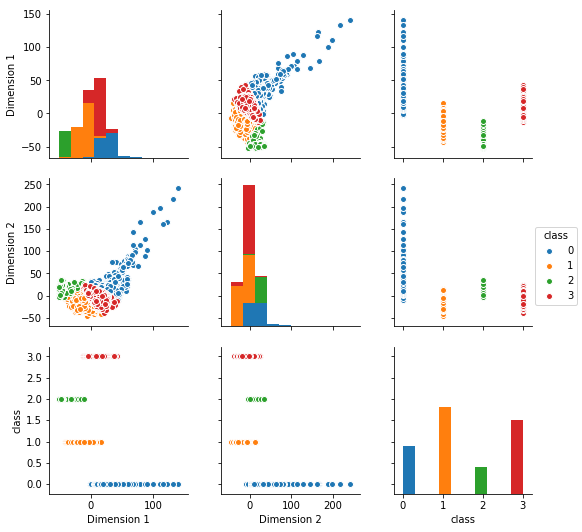

In [58]:
sns.pairplot(azdias_sample, hue="class")

In [61]:
customer['PRODUCT_GROUP'] = customers['PRODUCT_GROUP'].map({"COSMETIC":0,"COSMETIC_AND_FOOD":1,"FOOD":3})
customer['CUSTOMER_GROUP'] = customers['CUSTOMER_GROUP'].map({"MULTI_BUYER":0,"SINGLE_BUYER":1})
customer['ONLINE_PURCHASE'] = customers['ONLINE_PURCHASE']

In [62]:
# customer = customer.drop("Unnamed: 0",axis=1)
# fs = fs.drop("Unnamed: 0",axis=1)
col_coluns = [i for i in list(feature_socre.feature) if i in customer.columns]

In [63]:
feature_socre[feature_socre.feature.isin(col_coluns)].sort_values("score").iloc[:10]

,feature,score
36,D19_DIGIT_SERV,-1.066833
66,D19_TIERARTIKEL,-0.926120
27,D19_BANKEN_LOKAL,-0.852497
51,D19_LEBENSMITTEL,-0.823037
94,GFK_URLAUBERTYP,-0.803563
64,D19_TELKO_ONLINE_DATUM,-0.760967
50,D19_KOSMETIK,-0.729610
33,D19_BILDUNG,-0.720439
55,D19_SAMMELARTIKEL,-0.703288
80,D19_WEIN_FEINKOST,-0.694442


In [64]:
clusterer = KMeans(n_clusters=4,random_state=42).fit(reduced_azdias)
preds = clusterer.predict(reduced_azdias)
sample["class"] = preds

D19_TIERARTIKEL


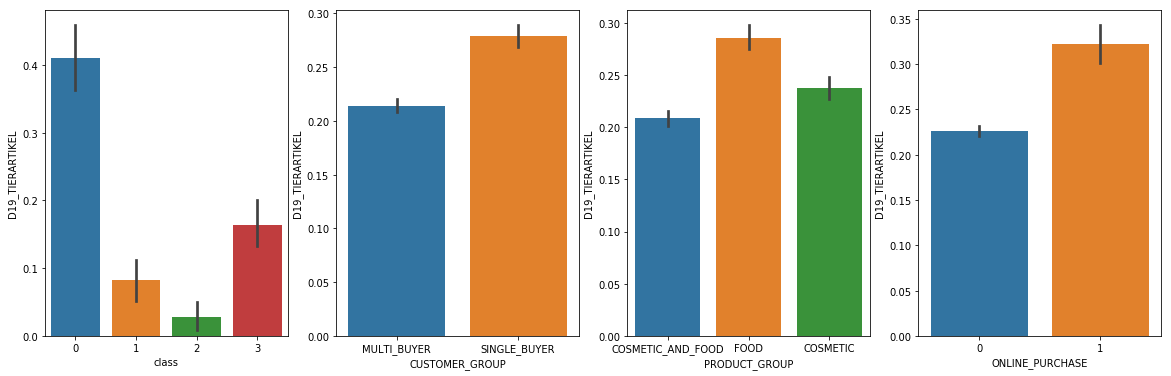

D19_BANKEN_LOKAL


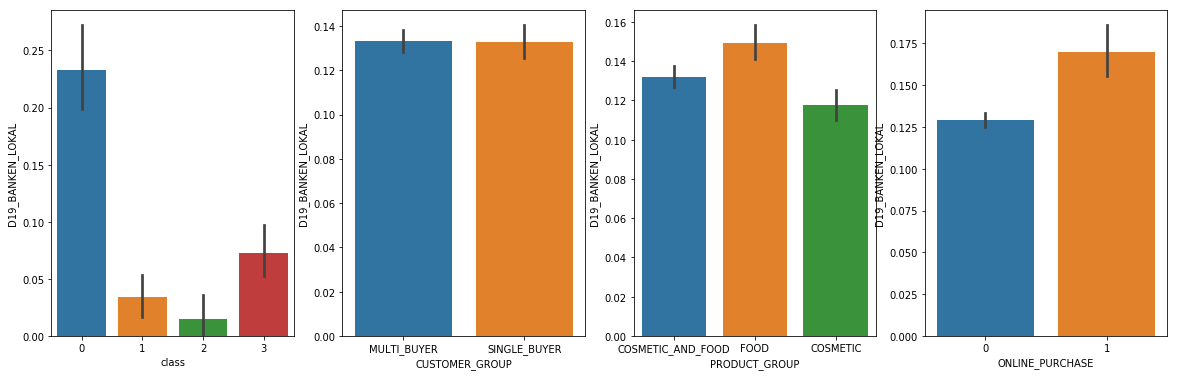

D19_LEBENSMITTEL


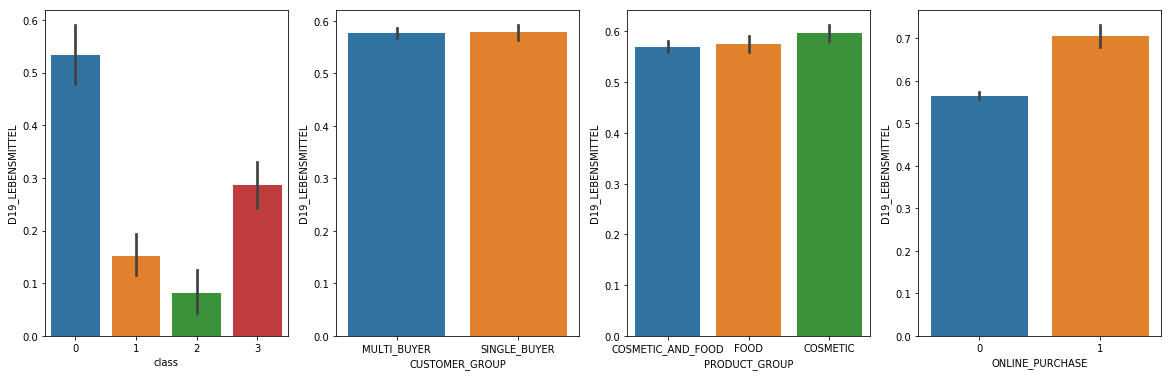

GFK_URLAUBERTYP


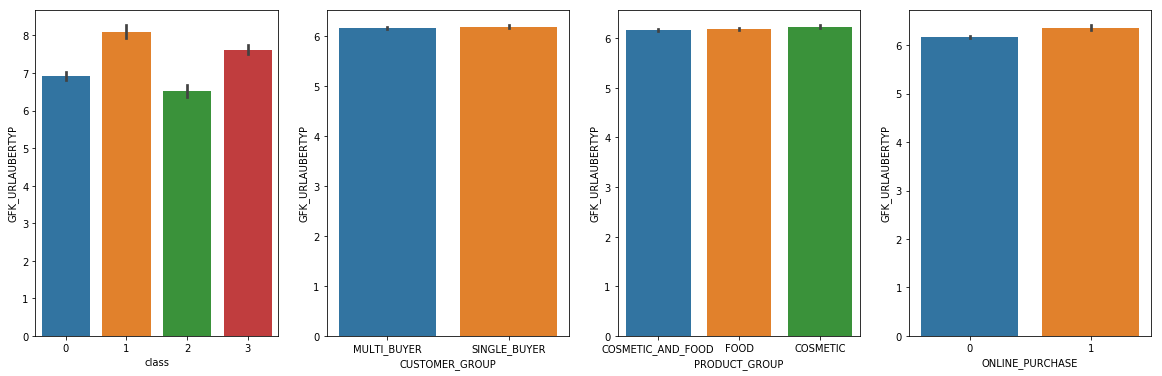

In [66]:

for i in list(feature_socre[feature_socre.feature.isin(col_coluns)].sort_values("score").iloc[:10]["feature"])[1:5]:
    print(i)
    x = i
    f, (ax1,ax2,ax3,ax4) =plt.subplots(1,4,figsize=(20,6))
    sns.barplot(y = sample[x],x = sample["class"],ax = ax1)
    sns.barplot(y = customer[x],x = customers["CUSTOMER_GROUP"] ,ax = ax2)
    sns.barplot(y = customer[x],x = customers["PRODUCT_GROUP"], ax = ax3)
    sns.barplot(y = customer[x],x = customers["ONLINE_PURCHASE"], ax = ax4)
    plt.show()

### According AZDIAS data feature D19_DIGIT_SERV and D19_TIERARTIKEL could discover the 1 and 3 classes of the four classes of clustering with coustome data CUSTOMER_GROUP feature two class 、PRODUCT_GROUP three class、ONLINE_PURCHASE two class have Associated.

this is my report url https://medium.com/@yangwang_57085/for-arvato-financial-services-find-value-customer-b7aa8445717b

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [52]:
import pandas as pd
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV 
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split, StratifiedKFold 
from sklearn.pipeline import Pipeline
from hyperopt import hp
from hyperopt import fmin, tpe, Trials
from hyperopt import space_eval
from sklearn.neural_network import MLPClassifier
from mlens.ensemble import SuperLearner
mailout_train = pd.read_csv('./Udacity_MAILOUT_052018_TRAIN.csv')

/root/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [53]:
mailout_train1 = clearn_data_other(mailout_train)
X  =  mailout_train1.drop('RESPONSE',axis=1)
y = mailout_train1['RESPONSE']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# mailout_train1.drop(drop_null,inplace=True)

In [54]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

X = mailout_train1.drop('RESPONSE',axis=1)
y = mailout_train1['RESPONSE']
clf = LogisticRegression(random_state=42).fit(X_train,y_train)
y_preds = clf.predict_proba(X_test)
score = metrics.roc_auc_score(y_test,y_preds[:,1])
print(score)

0.6864085662942406


In [55]:
from sklearn  import  tree
y = mailout_train1['RESPONSE']
X =  mailout_train1.drop('RESPONSE',axis=1)

clf = tree.DecisionTreeClassifier().fit(X_train,y_train)
y_preds = clf.predict_proba(X_test)
score = metrics.roc_auc_score(y_test,y_preds[:,1])
print(score)

0.5105881465595506


In [62]:
# 链接：https://www.jianshu.com/p/0fe45d4e9542
def gridsearch_cv(model, test_param, X, y, cv=5): 
    RandomizedSearchCV
    gsearch = GridSearchCV(model,test_param, scoring='roc_auc', n_jobs= -1, iid=False, cv=cv) 
#     gsearch = RandomizedSearchCV(model,test_param, scoring='roc_auc', n_jobs= -1, iid=False, cv=cv) 
    gsearch.fit(X, y) 
    return gsearch.best_estimator_

In [65]:
gb = GradientBoostingClassifier(random_state=42)
params = {'n_estimators': [20, 50, 100, 150], 
         'learning_rate': [0.01, 0.1, 1]}

best_gb = gridsearch_cv(gb,params,X_train,y_train,5)
best_predictions = best_gb.predict_proba(X_test)[:,1]

auc_score = roc_auc_score(y_test, best_predictions)
print(auc_score)
print(best_gb)

0.7634164611119469
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=150,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False)


In [ ]:
lgb_class = lgb.LGBMClassifier(random_state=42)
params = {'n_estimators': range(200,1000), 
         'learning_rate': [0.001, 0.005, 0.01, 0.1, 1],
         'max_depth' : range(2,30)
#          'num_leaves' : range(2,50),
#          'min_data_in_leaf' : range(2,10)
         }

best_lgb = gridsearch_cv(lgb_class,params,X_train,y_train,5)
best_predictions = best_lgb.predict_proba(X_test)[:,1]

auc_score = roc_auc_score(y_test, best_predictions)
print(auc_score)
print(best_lgb)

In [59]:
rf = RandomForestClassifier(random_state=42)
params = {
    'bootstrap' : [True,False],
    'max_depth' :range(5,20),
    'max_features' : range(1,11),
    'criterion' :['gini','entropy'],
    'n_estimators' : range(100,1000),
    'class_weight' :  [{0:75},{0:76},{0:77},{0:78},{0:79},{0:80},{0:81},{0:82},{0:83},{0:84}, {0:85}],
    'min_samples_leaf' : range(2,20),
    'min_samples_split' : range(2,10)
}
best_rf = gridsearch_cv(rf,params,X_train,y_train,5)
best_predictions = best_rf.predict_proba(X_test)[:,1]
auc_score = roc_auc_score(y_test, best_predictions)
print(auc_score)
print(best_rf)

0.7223562656710116
RandomForestClassifier(bootstrap=False, class_weight={0: 81},
            criterion='gini', max_depth=12, max_features=9,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=18,
            min_samples_split=3, min_weight_fraction_leaf=0.0,
            n_estimators=777, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)


In [60]:
mlp = MLPClassifier(random_state=42)
params = {
    'hidden_layer_sizes' : [(50,50,50), (80, 20), (70,30,10)],
    'activation' : ['tanh','relu'],
    'solver' : ['sgd','adam'],
    'learning_rate':['constant', 'adaptive']
}

best_mlp = gridsearch_cv(mlp,params,X_train,y_train,5)
best_predictions = best_mlp.predict_proba(X_test)[:,1]
auc_score = roc_auc_score(y_test, best_predictions)
print(auc_score)
print(best_mlp)

0.527932761358453
MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(50, 50, 50), learning_rate='adaptive',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=42, shuffle=True,
       solver='sgd', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)


In [63]:
lr = LogisticRegression(random_state=42, max_iter=4000, solver='lbfgs')
params = {
    "C" :[0.001, 0.01, 0.1, 1, 10]
}
best_lr = gridsearch_cv(lr,params,X_train,y_train,5)
best_predictions = best_lr.predict_proba(X_test)[:,1]
auc_score = roc_auc_score(y_test, best_predictions)
print(auc_score)
print(best_lr)

0.6782551507070935
LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=4000, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)


In [66]:
# print("Gaussian Naive Bayes: {} \n".format(roc_auc_score(y_test, predictions_nb)))
print("Random Forest: {} ".format(roc_auc_score(y_test, best_rf.predict_proba(X_test)[:,1])))
print("Gradient Boosting: {} ".format(roc_auc_score(y_test, best_gb.predict_proba(X_test)[:,1])))
print("LightGBM Classifier: {} ".format(roc_auc_score(y_test, best_lgb.predict_proba(X_test)[:,1])))
print("Multi-Layer Perceptron: {} ".format(roc_auc_score(y_test, best_mlp.predict_proba(X_test)[:,1])))
print("Logistic Regression: {} ".format(roc_auc_score(y_test, best_lr.predict_proba(X_test)[:,1])))

Random Forest: 0.7223562656710116 
Gradient Boosting: 0.7634164611119469 
LightGBM Classifier: 0.7621747523067289 
Multi-Layer Perceptron: 0.527932761358453 
Logistic Regression: 0.6782551507070935 


In [67]:
from sklearn.preprocessing import StandardScaler
def clearn_data(data,rate = 0.25):
    
    limit_percent = rate
    limit_value = len(data) * limit_percent
    drop_null = data.columns[data.isnull().sum() > limit_value]
    
    df = fill_missing_values(col_1,-1,data)
    df = fill_missing_values(col_1_0,-1,df)
    df = fill_missing_values(col_1_9,-1,df)
    df = fill_missing_values(col_1_0_none,-1,df)
    df = fill_missing_values(no_transactions_known_0,0,df)
    df = fill_missing_values(no_transactions_known_10,10,df)
    df = fill_missing_values(Online_transactions,0,df)
    df = fill_missing_values(Online_transactions,0,df)
#     df[numeric_col] = df[numeric_col].fillna(df[numeric_col].mean())
#     df[no_Domain_description] = df[no_Domain_description].fillna(df[no_Domain_description].median())
#     for n in no_feature:
#         df[n] = df[n].fillna(df[n].median())
        
    df = df.drop(drop_col,axis=1)
    df[string_col] = df[string_col].fillna(-1).astype(str)
    df["CAMEO_DEUG_2015"] = df["CAMEO_DEUG_2015"].replace('X',-1)
    df["CAMEO_DEUG_2015"] = df["CAMEO_DEUG_2015"].astype(int)
    from sklearn.preprocessing import StandardScaler,LabelEncoder
    df[scale_columns] = df[scale_columns].fillna(df[scale_columns].median())
    scale = StandardScaler()
    scale.fit(df[scale_columns])
    df[scale_columns] = scale.transform(df[scale_columns])
    le = LabelEncoder()
    for col in  string_col:
        le.fit(df[col])
        df[col] = le.transform(df[col])
    
    drop_null1 = [i for i in drop_null if i in df.columns]
    drop_null2 = [i for i in drop_null1 if i in df.columns]
    df = df.drop(drop_null2,axis=1)
    
    return df

In [68]:
mailout_train1 = clearn_data_other(mailout_train)
X  =  mailout_train1.drop('RESPONSE',axis=1)
y = mailout_train1['RESPONSE']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [69]:
mailout_train1.shape

(42962, 360)

In [70]:
import xgboost as xgb
seed = 1301
depth = 9
eta = 0.1
ntrees = 1000
mcw = 0.8

dtrain = xgb.DMatrix(X_train, y_train)
dvalid = xgb.DMatrix(X_test, y_test)
    
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]

param = {'max_depth': 6,
     'eta': 0.1,
     'subsample': 1,
     'alpha': 2, 
     'gamma': 2,
     'eval_metric': 'auc',
     'colsample_bytree': 0.5,
     'silent': 1,
     'objective': 'binary:logistic',
     'seed': 42,
     'lambda': 2,
     'tree_method': 'gpu_hist'}


print(param)
bst = xgb.train(param, dtrain, ntrees, watchlist, verbose_eval=10, early_stopping_rounds=10)

{'max_depth': 6, 'eta': 0.1, 'subsample': 1, 'alpha': 2, 'gamma': 2, 'eval_metric': 'auc', 'colsample_bytree': 0.5, 'silent': 1, 'objective': 'binary:logistic', 'seed': 42, 'lambda': 2, 'tree_method': 'gpu_hist'}
[0]	train-auc:0.5	eval-auc:0.5
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[10]	train-auc:0.785279	eval-auc:0.767273
[20]	train-auc:0.815368	eval-auc:0.766325
[30]	train-auc:0.850615	eval-auc:0.767444
[40]	train-auc:0.888837	eval-auc:0.775411
Stopping. Best iteration:
[37]	train-auc:0.881478	eval-auc:0.776176



In [71]:
pred_xgb = bst.predict(xgb.DMatrix(X_test))
auc_score = roc_auc_score(y_test, pred_xgb)
print(auc_score)

0.7761581932628069


## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
mailout_test = pd.read_csv('./Udacity_MAILOUT_052018_TEST.csv')

In [ ]:
mailout_test1 = clearn_data_other(mailout_test)

In [ ]:
sub_data = pd.read_csv("./Arvato_Capstone_Example_Submission.csv")

In [351]:
sub_data.RESPONSE = clf.predict_proba(mailout_test1)[:,1]
sub_data.to_csv('kaggle_sub1.csv', index=False)
sub_data.shape

(42833, 2)

In [51]:
sub_data.RESPONSE = bst.predict(xgb.DMatrix(mailout_test1))
sub_data.to_csv('./submition/kaggle_sub_xgb.csv', index=False)
sub_data.shape

(42833, 2)